In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor
from sklearn.datasets import fetch_lfw_people
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image



In [2]:
lfw_people = fetch_lfw_people(data_home='data', min_faces_per_person=5, color=True)

# Get the image data and labels
images = lfw_people.images
labels = lfw_people.target


In [3]:
class LFWPairsDataset(Dataset):
  """
    A custom PyTorch Dataset class for the Labeled Faces in the Wild (LFW) pairs dataset.

    This class loads image pairs from the LFW dataset along with their similarity labels
    (1 for similar, 0 for dissimilar).

    Args:
        root (str): The root directory of the LFW dataset containing the image folders.
        pairs_file (str): The path to the file containing the list of image pairs and
            their similarity labels.
        transform (callable, optional): An optional transform to be applied to the
            images. Default is None.

    Attributes:
        root (str): The root directory of the LFW dataset.
        transform (callable, optional): The transform to be applied to the images.
        pairs (list): A list of tuples, each containing two image paths and their
            similarity label (1 for similar, 0 for dissimilar).
    """
    def __init__(self, root, pairs_file, transform=None):
        self.root = root
        self.transform = transform
        self.pairs = []
        
        with open(pairs_file, 'r') as file:
            for line in file.readlines()[1:]:
                elements = line.strip().split()
                if len(elements) == 3:
                    img1_path = os.path.join(root, elements[0], elements[0] + '_' + f'{int(elements[1]):04d}.jpg')
                    img2_path = os.path.join(root, elements[0], elements[0] + '_' + f'{int(elements[2]):04d}.jpg')
                    label = 1
                else:
                    img1_path = os.path.join(root, elements[0], elements[0] + '_' + f'{int(elements[1]):04d}.jpg')
                    img2_path = os.path.join(root, elements[2], elements[2] + '_' + f'{int(elements[3]):04d}.jpg')
                    label = 0
                
                self.pairs.append((img1_path, img2_path, label))

    def __len__(self):
      """
        Return the total number of image pairs in the dataset.

        Returns:
            int: The number of image pairs in the dataset.
        """
        return len(self.pairs)

    def __getitem__(self, idx):
      """
        Get the image pair and their similarity label at the given index.

        Args:
            idx (int): The index of the image pair.

        Returns:
            tuple: A tuple containing the following elements:
                - img1 (PIL.Image.Image or torch.Tensor): The first image in the pair.
                - img2 (PIL.Image.Image or torch.Tensor): The second image in the pair.
                - label (torch.Tensor): The similarity label (1 for similar, 0 for dissimilar).
        """
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [4]:
root = "/content/data/lfw_home/lfw_funneled"
pairs_train_file = "/content/data/lfw_home/pairsDevTrain.txt"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [5]:
train_pairs_dataset = LFWPairsDataset(root, pairs_train_file, transform)
train_loader = DataLoader(train_pairs_dataset, batch_size=64, shuffle=True)


In [6]:
pairs_test_file = '/content/data/lfw_home/pairsDevTest.txt'

In [7]:
test_pairs_dataset = LFWPairsDataset(root, pairs_test_file, transform)
test_loader = DataLoader(test_pairs_dataset, batch_size=64, shuffle=False)

In [8]:
# class SiameseNetwork(nn.Module):
#     def __init__(self, alexnet):
#         super(SiameseNetwork, self).__init__()
#         self.feature_extractor = nn.Sequential(*list(alexnet.features.children()), nn.Flatten())
#         self.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])

#     def forward(self, x1, x2):
#         x1 = self.feature_extractor(x1)
#         x1 = self.classifier(x1)
#         x2 = self.feature_extractor(x2)
#         x2 = self.classifier(x2)
#         return x1, x2


# Siamese Network with VGG-16 (NO FINE-TUNING)

In [9]:
class SiameseNetwork(nn.Module):
     """
    A custom PyTorch Siamese Network class based on a pre-trained VGG16 model.

    This class implements a Siamese Network that uses a pre-trained VGG16 model for
    feature extraction and classification. The feature extraction layers are fine-tuned while
    the classifier layers are frozen.

    Args:
        vgg16 (torchvision.models.VGG): A pre-trained VGG16 model.

    Attributes:
        feature_extractor (nn.Sequential): A sequence of layers responsible for
            feature extraction, including convolutional and pooling layers.
        classifier (nn.Sequential): A sequence of fully connected layers responsible
            for classification.
    """
    def __init__(self, vgg16):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = nn.Sequential(*list(vgg16.features.children()), nn.Flatten())
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1]) # outputs of second to last fully - connected layer passed into Siamese Network

    def forward(self, x1, x2):
       """
        Perform a forward pass of the Siamese Network for a pair of input images.

        Args:
            x1 (torch.Tensor): The first image in the pair with shape (batch_size, channels, height, width).
            x2 (torch.Tensor): The second image in the pair with shape (batch_size, channels, height, width).

        Returns:
            tuple: A tuple containing the following elements:
                - x1 (torch.Tensor): The output feature vector of the first image with shape (batch_size, feature_dim).
                - x2 (torch.Tensor): The output feature vector of the second image with shape (batch_size, feature_dim).
        """
        x1 = self.feature_extractor(x1)
        x1 = self.classifier(x1)
        x2 = self.feature_extractor(x2)
        x2 = self.classifier(x2)
        return x1, x2


In [10]:
class CosineContrastiveLoss(nn.Module):
  """
    A custom PyTorch loss function class that implements cosine contrastive loss.

    The loss function measures the similarity between two feature vectors using
    cosine similarity, and the loss is calculated based on the similarity and
    ground truth labels.

    Args:
        margin (float, optional): The margin used to separate dissimilar pairs.
            Default is 0.5.

    Attributes:
        margin (float): The margin used to separate dissimilar pairs.
    """
    def __init__(self, margin=0.5):
        super(CosineContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
       """
        Calculate the cosine contrastive loss for a batch of feature vectors.

        Args:
            output1 (torch.Tensor): The first set of feature vectors with shape
                (batch_size, feature_dim).
            output2 (torch.Tensor): The second set of feature vectors with shape
                (batch_size, feature_dim).
            label (torch.Tensor): The ground truth similarity labels for the pairs
                of feature vectors (1 for similar, 0 for dissimilar) with shape
                (batch_size,).

        Returns:
            torch.Tensor: The mean cosine contrastive loss for the batch.
        """
        cosine_similarity = nn.functional.cosine_similarity(output1, output2)
        loss = (1 - label) * torch.pow(cosine_similarity, 2) + \
               label * torch.pow(torch.clamp(self.margin - cosine_similarity, min=0.0), 2)
        return loss.mean()


In [11]:
vgg16 = models.vgg16(pretrained=True)
siamese_net = SiameseNetwork(vgg16)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 256MB/s]


# Evaluation/Inference

In [12]:
def compute_cosine_similarity(x1, x2):
  """
    Compute the cosine similarity between two sets of feature vectors.

    The function computes the cosine similarity for each pair of feature vectors
    from the input sets x1 and x2.

    Args:
        x1 (torch.Tensor): The first set of feature vectors with shape
            (batch_size, feature_dim).
        x2 (torch.Tensor): The second set of feature vectors with shape
            (batch_size, feature_dim).

    Returns:
        torch.Tensor: A tensor containing the cosine similarity scores for each
            pair of feature vectors with shape (batch_size,).
    """
    normalized_x1 = x1 / torch.norm(x1, dim=1, keepdim=True)
    normalized_x2 = x2 / torch.norm(x2, dim=1, keepdim=True)
    return torch.sum(normalized_x1 * normalized_x2, dim=1)


In [13]:
def evaluate_siamese_network(test_loader, siamese_net):
   """
    Evaluate a Siamese network on a given test dataset.

    This function computes the cosine similarity between feature representations of
    image pairs generated by the Siamese network and returns the similarities and
    corresponding ground truth labels.

    Args:
        test_loader (torch.utils.data.DataLoader): The test dataset loader, which
            should yield image pairs and their corresponding labels (1 for similar,
            0 for dissimilar).
        siamese_net (torch.nn.Module): The Siamese network to be evaluated.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - similarities (numpy.ndarray): An array of shape (N,) containing the
                cosine similarities between the image pairs.
            - labels (numpy.ndarray): An array of shape (N,) containing the ground
                truth labels for the image pairs (1 for similar, 0 for dissimilar).
    """
    siamese_net.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    siamese_net.to(device)  # Add this line to move the Siamese network to the device
    similarities = []
    labels = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = siamese_net(img1, img2)
            similarity = compute_cosine_similarity(output1, output2)
            similarities.append(similarity.cpu().numpy())
            labels.append(label.cpu().numpy())

    similarities = np.concatenate(similarities)
    labels = np.concatenate(labels)
    return similarities, labels


In [14]:
similarities, labels = evaluate_siamese_network(test_loader, siamese_net)


# ROC/AUC

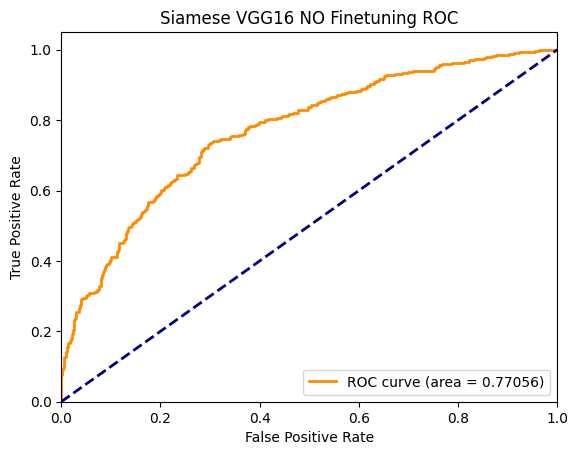

In [16]:
fpr, tpr, _ = roc_curve(labels, similarities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Siamese VGG16 NO Finetuning ROC')
plt.legend(loc="lower right")
plt.show()


### trying to find optimal threshold

In [17]:
j_statistic = tpr - fpr
optimal_idx = np.argmax(j_statistic)
optimal_threshold = _[optimal_idx]


In [18]:
print("Optimal Threshold: ", optimal_threshold)

Optimal Threshold:  0.509655


In [19]:
# from sklearn.metrics import precision_recall_curve

# def find_optimal_threshold(y_true, y_scores):
#     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
#     epsilon = 1e-8
#     f1_scores = 2 * (precisions * recalls) / (precisions + recalls + epsilon)
#     optimal_threshold_index = np.argmax(f1_scores)
#     return thresholds[optimal_threshold_index]

In [20]:
# optimal_threshold = find_optimal_threshold(labels, similarities)

In [23]:
# print("Optimal Threshold: ", optimal_threshold)

Optimal Threshold:  0.47594956


### Similarity Score Statistics

In [21]:
import statistics

avg = statistics.mean(similarities)
print("Average:", avg)

Average: 0.5266779


In [22]:
maximum = max(similarities)
minimum = min(similarities)
print("Maximum:", maximum)
print("Minimum:", minimum)

Maximum: 0.9380852
Minimum: 0.19225107
